In [ ]:
%load_ext autoreload
%autoreload 2
%pip install prettytable

In [1]:
# import basic package
import os
import pandas as pd
import warnings
import json

warnings.filterwarnings("ignore")
# import the necessary package
from baseline.PyOD import PYOD
from baseline.OE_GPLVM.aeb_gplvm import AEB_GPLVM, NNEncoder
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import VariationalELBO
from gpytorch.distributions import MultivariateNormal
from gpytorch.priors import NormalPrior, MultivariateNormalPrior

from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import torch
import numpy as np
from tqdm import trange

datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

2023-07-10 20:39:01.397715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 20:39:01.434909: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# dataset and model list / dict
dataset_list = [
    "01_ALOI",
    "02_annthyroid",
    "03_backdoor",
    "04_breastw",
    "05_campaign",
    "06_cardio",
    "07_Cardiotocography",
    "08_celeba",
    "09_census",
    "99_linear",
]

In [3]:
dataset = dataset_list[-1]
datagenerator.dataset = dataset
data = datagenerator.generator(la=1.0, realistic_synthetic_mode=None, noise_type=None)

generating duplicate samples for dataset 99_linear...
current noise type: None
{'Samples': 1000, 'Features': 2, 'Anomalies': 523, 'Anomalies Ratio(%)': 52.3}


In [29]:
Y_train = torch.tensor(data["X_train"], dtype=torch.float32)
Y_test = torch.tensor(data["X_test"], dtype=torch.float32)
lb_train = torch.tensor(data["y_train"], dtype=torch.float32)
lb_test = torch.tensor(data["y_test"], dtype=torch.float32)

In [31]:
model_dict = {}
noise_trace_dict = {}
N = len(Y_train)
data_dim = Y_train.shape[1]
latent_dim = 2
n_inducing = 25
batch_size = 100
n_epochs = 1000
nn_layers = (10, 5)
lr = 0.01

# Define prior for X, Initialise model, likelihood, elbo and optimizer and latent variable encoder
X_prior_mean = torch.zeros(N, latent_dim)  # shape: N x Q
prior_x = MultivariateNormalPrior(X_prior_mean, torch.eye(X_prior_mean.shape[1]))
encoder = NNEncoder(N, latent_dim, prior_x, data_dim, layers=nn_layers)
model = AEB_GPLVM(N, data_dim, latent_dim, n_inducing, encoder, nn_layers=nn_layers)
likelihood = GaussianLikelihood()
optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}], lr
)
elbo = VariationalELBO(likelihood, model, num_data=len(Y_train), combine_terms=False)
# Model params
print(f'Training model params for model {"GPLVM"}')
model.get_trainable_param_names()
loss_list = []
noise_trace = []

Training model params for model GPLVM
+-----------------------------------------------------------------------+------------+
|                                Modules                                | Parameters |
+-----------------------------------------------------------------------+------------+
|                  variational_strategy.inducing_points                 |     50     |
|    variational_strategy._variational_distribution.variational_mean    |     50     |
| variational_strategy._variational_distribution.chol_variational_covar |    1250    |
|                          X.mu_layers.0.weight                         |     20     |
|                           X.mu_layers.0.bias                          |     10     |
|                          X.mu_layers.1.weight                         |     50     |
|                           X.mu_layers.1.bias                          |     5      |
|                          X.mu_layers.2.weight                         |     10     |
|    

In [ ]:
# Provando o conceito
batch_idx_a = np.arange(1, 30)
batch_idx_n = np.arange(32, 100)
batch_index = np.hstack([batch_idx_a, batch_idx_n])

In [ ]:
ratio = len(batch_idx_a) / len(batch_index)

In [ ]:
output_batch_a = model(model.sample_latent_variable(Y_train)[batch_idx_a])
output_batch_n = model(model.sample_latent_variable(Y_train)[batch_idx_n])
output_batch_full = model(model.sample_latent_variable(Y_train)[batch_index])

In [ ]:
# O método forward da classe VariationalELBO, chama a superclasse _ApproximateMarginalLogLikelihood
# que retorna log_likelihood - kl_divergence + log_prior - added_loss, quando você pede pra combinar os termos
# que  é o PADRÃO. Se você passar combine_terms = False, ele te retorna uma tupla com cada um deles
log_likelihood, kl_divergence, log_prior, added_loss = elbo(
    output_batch_full, Y_train[batch_index].T
)
terms = dict(
    log_likelihood=log_likelihood,
    kl_divergence=kl_divergence,
    log_prior=log_prior,
    added_loss=added_loss,
)
terms

In [ ]:
# Minha duvida era se eu conseguia separar as likelihoods e voltar para o resultado original
# por conta dos termos KL não era trivial, a principio fazer isso
log_likelihood, kl_divergence, log_prior, added_loss = elbo(
    output_batch_n, Y_train[batch_idx_n].T
)
terms = dict(
    log_likelihood=log_likelihood,
    kl_divergence=kl_divergence,
    log_prior=log_prior,
    added_loss=added_loss,
)
terms

In [ ]:
# Aparentemente os termos KL e Added Loss que também é um KL, são constantes nas chamadas do elbo
# então posso somente armazena-los e focar na log_likelihood
log_likelihood, kl_divergence, log_prior, added_loss = elbo(
    output_batch_n, Y_train[batch_idx_n].T
)
terms = dict(
    log_likelihood=log_likelihood,
    kl_divergence=kl_divergence,
    log_prior=log_prior,
    added_loss=added_loss,
)
terms

In [ ]:
# Essa é o método principal da classe VariationalELBO, o problem é que ele já vem somado no shape 1xDIM_DADOS
# mas preciso saber esse termo por cada ponto do batch/teste
terms = {
    "_log_likelihood_term": elbo._log_likelihood_term(
        output_batch_full, Y_train[batch_index].T
    )
}
terms

In [ ]:
# Eu posso pegar toda a matriz, utilizando a chamada da likelihood
exp_log_prob = elbo.likelihood.expected_log_prob(
    Y_train[batch_index].T, output_batch_full
)
print(exp_log_prob, exp_log_prob.shape)

In [ ]:
# LEMBRANDO QUE ---> exp_log_prob.sum(-1).div(batch_size) == elbo(target = Y_train[batch_index].T, variational_dist_f= output_batch_full)[0]
## IMPORTANTE!!! Se atentar aos gradienets, basta multiplicar exp_log_prob.sum(-1).div(batch_size) por *1 para ver o B.O.
batch_size = len(batch_index)
exp_log_prob.sum(-1).div(batch_size)

In [ ]:
# LL TOTAL
log_likelihood_total = elbo(
    target=Y_train[batch_index].T, variational_dist_f=output_batch_full
)[0]

# Depois de muito sofrer pensando isso, percebi que posso fazer passar chamar o elbo
# pra cada conjunto, anomalo e normal, e depois recuperar o log_likelihood total
# se eu fizer uma soma ponderada dos log_likelihoods
# Minha preocupacao aqui era por que na instaciação da classe você precisa
# passar o num_data, só que esse termo se não diz respeito ao tamanno do batch
# e sim ao tamanho do treino total. Em todos os experimentos do GPLVM
# ele é instanciado utilizado num_data = len(Y_train), logo isso não interfere
# no calculo do elbo. Também é legal ressaltar que os termos KL não mudam
# mesmo que os batchs mudem.

output_batch_a = model(model.sample_latent_variable(Y_train)[batch_idx_a])
output_batch_n = model(model.sample_latent_variable(Y_train)[batch_idx_n])
target_a = Y_train[batch_idx_a].T
target_n = Y_train[batch_idx_n].T
ll_normal = elbo(output_batch_n, target_n)[0] * (
    1 - ratio
)  # <- Isso não é o elbo. É a log_likelihood --> Se atentar ao [0]
ll_anomaly = elbo(output_batch_a, target_a)[0] * ratio

In [ ]:
log_likelihood_total

In [ ]:
ll_normal + ll_anomaly

In [32]:
def get_loe_index(score, ratio, batch_index):
    _, idx_n = torch.topk(
        score, int(score.shape[0] * (1 - ratio)), largest=False, sorted=False
    )
    _, idx_a = torch.topk(
        score, int(score.shape[0] * (ratio)), largest=True, sorted=False
    )
    return batch_index[idx_n], batch_index[idx_a]

In [33]:
def get_log_likelihood_LOE(Y_train, lb_train, idx_n, idx_a, ratio, method="blind"):
    output_batch_a = model(model.sample_latent_variable(Y_train)[idx_a])
    output_batch_n = model(model.sample_latent_variable(Y_train)[idx_n])
    target_a = Y_train[idx_a].T
    target_n = Y_train[idx_n].T

    ll_normal = elbo(output_batch_n, target_n)[0] * (1 - ratio)
    ll_anomaly = elbo(output_batch_a, target_a)[0] * ratio

    if method == "blind":
        log_likelihood = (ll_normal + ll_anomaly).div(1)
    elif method == "hard":
        log_likelihood = (ll_normal - ll_anomaly).div(1)
    elif method == "soft":
        log_likelihood = (ll_normal - 0.5 * (ll_anomaly + ll_normal)).div(1)
    else:
        raise NotImplementedError

    return log_likelihood

In [34]:
def elbo_loe(model, elbo, batch_size, Y_train, y_train, method="refine"):
    if method == "refine":
        batch_index = model._get_normal_batch_idx(batch_size, y_train)
        output_batch = model(model.sample_latent_variable(Y_train)[batch_index])

        log_likelihood, kl_divergence, log_prior, added_loss = elbo(
            output_batch, Y_train[batch_index].T
        )

    elif method in ["hard", "soft", "blind"]:
        batch_index, ratio = model._get_individual_batch_idx(batch_size, y_train)
        Y_target = Y_train[batch_index]
        output_batch = model(model.sample_latent_variable(Y_train)[batch_index])

        _, kl_divergence, log_prior, added_loss = elbo(output_batch, Y_target.T)
        likelihood_per_point = elbo.likelihood.expected_log_prob(
            Y_target.T, output_batch
        ).sum(0)
        loe_idx_n, loe_idx_a = get_loe_index(likelihood_per_point, ratio, batch_index)
        log_likelihood = get_log_likelihood_LOE(Y_train, y_train, loe_idx_n, loe_idx_a, ratio)

    loss = -(log_likelihood - kl_divergence + log_prior - added_loss).sum()

    return loss

In [35]:
iterator = trange(1000, leave=True)
batch_size = 100
for i in iterator:
    model.train()
    optimizer.zero_grad()
    loss = elbo_loe(model, elbo, batch_size, Y_train, lb_train, method="refine")
    loss_list.append(loss.item())
    noise_trace.append(np.round(likelihood.noise_covar.noise.item(), 3))
    if i % 50 == 0:
        iterator.set_description(
            "Loss: " + str(float(np.round(loss.item(), 2))) + ", iter no: " + str(i)
        )
    loss.backward()
    optimizer.step()

model.store(loss_list, likelihood)
noise_trace_dict["GPLVM"] = noise_trace
X_train_mean = model.get_X_mean(Y_train)

Loss: -2.21, iter no: 950: 100%|██████████| 1000/1000 [00:07<00:00, 136.17it/s]


In [22]:
with torch.no_grad():
    model.eval()
    likelihood.eval()
y_pred_mean, y_pred_covar = model.reconstruct_y(Y_test)
dist_pred = MultivariateNormal(y_pred_mean, y_pred_covar)
elbo_per_point = elbo.likelihood.expected_log_prob(Y_test.T, dist_pred).sum(0)

In [23]:
utils.metric(y_true = lb_test, y_score = elbo_per_point.detach().numpy())

{'aucroc': 0.0, 'aucpr': 0.3315371969762526}

In [36]:
## amostra -> nn_ecoder --> model.decoder --> amostra_reconstruida
## ou seja, vira uma variavel latente, depois passa pelo modelo
## para se tornar de novo algo no espaço dos dados
X_test_mean, X_test_covar = model.predict_latent(Y_test)
Y_test_mean, Y_test_covar = model.reconstruct_y(Y_test)

In [37]:
def scatter_Y_test(Y_test, lb_test):
    idx_n = np.where(lb_test == 0)
    idx_a = np.where(lb_test == 1)
    plt.scatter(Y_test_mean[0, idx_a], Y_test_mean[1, idx_a])
    plt.scatter(Y_test_mean[0, idx_n], Y_test_mean[1, idx_n])

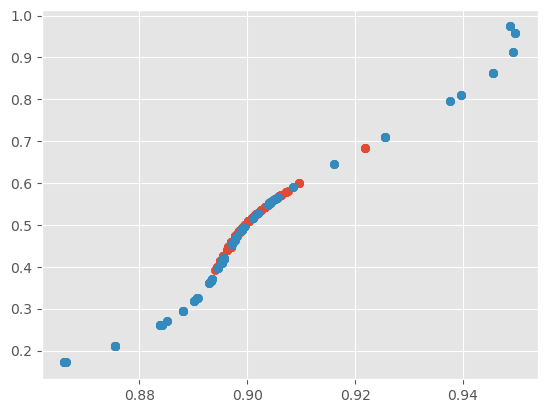

In [38]:
scatter_Y_test(Y_test, lb_test)

In [ ]:
# seed for reproducible results
seed = 42

# clf = clf(seed=seed, model_name=name)
# clf = clf.fit(X_train=data["X_train"], y_train=data["y_train"])
# score = clf.predict_score(data["X_test"])
# result = utils.metric(y_true=data["y_test"], y_score=score)
# df_AUCROC.loc[dataset, name] = result["aucroc"]
# df_AUCPR.loc[dataset, name] = result["aucpr"]